In [1]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as td
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import image
from matplotlib import pyplot
import time

In [3]:
from numpy.core.fromnumeric import shape
def load_data(path,batch_size,input_size):
    
    normalize = transforms.Compose([
        transforms.Resize((input_size,input_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ]) 
    transform_dict = {"src":  normalize}  
    data = datasets.ImageFolder(root=path,transform=transform_dict["src"])
    train_size=int(0.75*len(data))
    print(len(data))
    test_size=int(len(data)-train_size)
    train, test = td.random_split(data,[train_size,test_size])

    data_loader_train = td.DataLoader(train,batch_size=batch_size,shuffle=True,drop_last=False,num_workers=0)
    data_loader_test = td.DataLoader(test,batch_size=batch_size,shuffle=True,drop_last=False,num_workers=0)
    return data_loader_train, data_loader_test

In [4]:
data_loader_train,data_loader_test=load_data(r"/content/gdrive/MyDrive/Colab Notebooks/Dataset1",32,64)

21165


In [5]:
data_loader_train.dataset

In [6]:
import torch.optim as optim
from torchvision.models import resnet50
net=resnet50(weights=None)
resnet50(pretrained=False) 

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience=5)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [7]:
###### Define and run your training loop here #########
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
net.to(device)
Accuracies=[]
num_epochs = 50
total_steps = len(data_loader_train)
t1 = time.time()
for epoch in range(num_epochs):
    for i, data in enumerate(data_loader_train):
        images, labels = data[0].to(device), data[1].to(device)
        # Forward pass
        outputs = net(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total = labels.size(0)
        _,predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        if (i + 1) % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                .format(epoch + 1, num_epochs, i + 1, total_steps, loss.item(),
                    (correct / total) * 100))
            Accuracies.append((correct / total) * 100)
            
print("######## Training Finished in {} seconds ###########".format(time.time()-t1))

Device: cuda:0
Epoch [1/50], Step [10/497], Loss: 4.7723, Accuracy: 53.12%
Epoch [1/50], Step [20/497], Loss: 2.5941, Accuracy: 50.00%
Epoch [1/50], Step [30/497], Loss: 2.0573, Accuracy: 25.00%
Epoch [1/50], Step [40/497], Loss: 1.5168, Accuracy: 53.12%
Epoch [1/50], Step [50/497], Loss: 1.4726, Accuracy: 50.00%
Epoch [1/50], Step [60/497], Loss: 1.2447, Accuracy: 50.00%
Epoch [1/50], Step [70/497], Loss: 1.0756, Accuracy: 59.38%
Epoch [1/50], Step [80/497], Loss: 1.1799, Accuracy: 40.62%
Epoch [1/50], Step [90/497], Loss: 1.1357, Accuracy: 56.25%
Epoch [1/50], Step [100/497], Loss: 1.4905, Accuracy: 40.62%
Epoch [1/50], Step [110/497], Loss: 1.4099, Accuracy: 31.25%
Epoch [1/50], Step [120/497], Loss: 1.2464, Accuracy: 56.25%
Epoch [1/50], Step [130/497], Loss: 1.2829, Accuracy: 43.75%
Epoch [1/50], Step [140/497], Loss: 1.0575, Accuracy: 59.38%
Epoch [1/50], Step [150/497], Loss: 1.1728, Accuracy: 53.12%
Epoch [1/50], Step [160/497], Loss: 1.0574, Accuracy: 62.50%
Epoch [1/50], Step

Test Accuracy of the model on the 5292 test images: 47.95918367346938 %


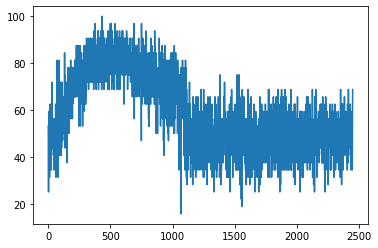

In [8]:
net.eval() 
perds = []
target = []
with torch.no_grad(): 
    correct = 0
    total = 0
    for data in data_loader_test:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        perds.extend(predicted)
        target.extend(labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Test Accuracy of the model on the {} test images: {} %'
        .format(total, (correct / total) * 100))
    
plt.plot(Accuracies)    

In [ ]:
!pip install torchmetrics

In [10]:
from torchmetrics.functional import precision_recall
from torchmetrics import F1Score
from torchmetrics import ConfusionMatrix
perds1 = torch.stack(perds)
target1 = torch.stack(target)
f1 = F1Score(num_classes=4).to(device)
print(f1(perds1, target1))
print(precision_recall(perds1, target1, average='macro', num_classes=4))
confmat = ConfusionMatrix(num_classes=4).to(device)
confmat(perds1, target1)

tensor(0.4796, device='cuda:0')
(tensor(0.1199, device='cuda:0'), tensor(0.2500, device='cuda:0'))


tensor([[   0,    0,  892,    0],
        [   0,    0, 1531,    0],
        [   0,    0, 2538,    0],
        [   0,    0,  331,    0]], device='cuda:0')